In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
torch.manual_seed(0);

# Part (a)

See Attached Drawing

# Part (b)

# Part (i)

In [3]:
# Import over-35 dataset
df = pd.read_csv('london_data_35+.csv')
y = pd.CategoricalIndex(df.travel_mode).codes
X = df.loc[:, df.columns != 'travel_mode'].to_numpy()

# Standardize
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Build train and validation dataloaders
batch_size = 128
X_train, y_train = X[:40000], y[:40000]
X_val, y_val = X[40000:], y[40000:]
train_dataset = TensorDataset(Tensor(X_train.copy()), Tensor(y_train.copy()))
val_dataset = TensorDataset(Tensor(X_val.copy()), Tensor(y_val.copy()))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

## Train Neural Network

In [3]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(22, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 4),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [4]:
NN = NeuralNetwork()
optimizer = torch.optim.Adam(NN.parameters(), lr=1e-4)
CrossEntropy = nn.CrossEntropyLoss(reduction='mean')

In [20]:
train_acc_history = []
val_acc_history = []

for epoch in range(150):

    # Training loop
    train_acc = 0.0
    for batch, (X, y) in enumerate(train_loader):
        pred = NN(X) # predict logits
        loss = CrossEntropy(pred, y.type(torch.LongTensor)) # compute Cross Entropy loss
        loss.backward() # backward pass
        optimizer.step() # update step
        optimizer.zero_grad()
        train_acc += (pred.softmax(dim=1).argmax(dim=1) == y).type(torch.float).sum() / len(train_dataset)
    train_acc_history.append(train_acc)

    # Validation loop
    val_acc = 0.0
    with torch.no_grad():
        for batch, (X, y) in enumerate(val_loader):
            pred = NN(X)
            loss = CrossEntropy(pred, y.type(torch.LongTensor))
            val_acc += (pred.softmax(dim=1).argmax(dim=1) == y).type(torch.float).sum() / len(val_dataset)
        val_acc_history.append(val_acc)

    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1} train accuracy:, {round(float(train_acc), 4)}, validation accuracy:, {round(float(val_acc), 4)}")

Epoch 5 train accuracy:, 0.7271, validation accuracy:, 0.7251
Epoch 10 train accuracy:, 0.7351, validation accuracy:, 0.7344
Epoch 15 train accuracy:, 0.7405, validation accuracy:, 0.7374
Epoch 20 train accuracy:, 0.7441, validation accuracy:, 0.7395
Epoch 25 train accuracy:, 0.7468, validation accuracy:, 0.7416
Epoch 30 train accuracy:, 0.7491, validation accuracy:, 0.7452
Epoch 35 train accuracy:, 0.7509, validation accuracy:, 0.7468
Epoch 40 train accuracy:, 0.7523, validation accuracy:, 0.747
Epoch 45 train accuracy:, 0.7531, validation accuracy:, 0.7485
Epoch 50 train accuracy:, 0.7538, validation accuracy:, 0.7487
Epoch 55 train accuracy:, 0.7538, validation accuracy:, 0.7475
Epoch 60 train accuracy:, 0.7544, validation accuracy:, 0.7481
Epoch 65 train accuracy:, 0.7551, validation accuracy:, 0.7485
Epoch 70 train accuracy:, 0.7558, validation accuracy:, 0.75
Epoch 75 train accuracy:, 0.7562, validation accuracy:, 0.75
Epoch 80 train accuracy:, 0.7569, validation accuracy:, 0.751

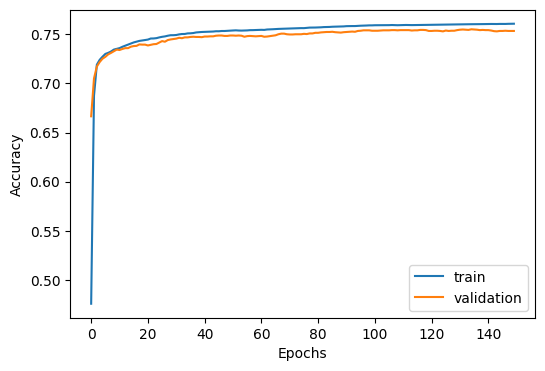

In [21]:
fig = plt.figure(figsize=(6,4))
plt.plot(train_acc_history, label='train')
plt.plot(val_acc_history, label='validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

## Train Logistic Regression Model

In [22]:
# Training multi-class logistic regression model
logistic = LogisticRegression(max_iter=5000, penalty=None).fit(X_train, y_train)
print('train accuracy:', round(logistic.score(X_train, y_train), 3))
print('validation accuracy:', round(logistic.score(X_val, y_val), 3))

train accuracy: 0.736
validation accuracy: 0.737


||Training Accuracy|Validation Accuracy|
|-|-|-|
|NN|0.7670|0.7534|
|Logistic|0.736|0.737|



# Part (ii)

## Compare out-of-distribution accuracy

In [23]:
# Import under-35 dataset
df = pd.read_csv('london_data_35-.csv')
y = pd.CategoricalIndex(df.travel_mode).codes
X = df.loc[:, df.columns != 'travel_mode'].to_numpy()
X = scaler.transform(X)

pred = NN(Tensor(X.copy()))
acc = (pred.softmax(dim=1).argmax(dim=1) == Tensor(y.copy())).type(torch.float).sum() / X.shape[0]
print('NN accuracy:', round(float(acc), 3))
print('logistic accuracy:', round(logistic.score(X, y), 3))

NN accuracy: 0.658
logistic accuracy: 0.703


NN Test Accuracy: 0.658 <br>
Logistic Test Accuracy: 0.703 <br>
The Logistic model suffered less of a reduction in the accuracy from the covariate shift.


# Part (iii)

In [24]:
df = pd.concat([pd.read_csv('london_data_35-.csv'), pd.read_csv('london_data_35-.csv')])
y = pd.CategoricalIndex(df.travel_mode).codes
X = df.loc[:, df.columns != 'travel_mode'].to_numpy()

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
train_dataset = TensorDataset(Tensor(X_train), Tensor(y_train))
val_dataset = TensorDataset(Tensor(X_val), Tensor(y_val))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

## Tune network architecture

In [25]:
# Tune the following neural network architecture
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(in_features=22, out_features=1000), 
            nn.ReLU(),                                   
            nn.Linear(in_features=1000, out_features=1000),
            nn.ReLU(),                                   
            nn.Linear(in_features=1000, out_features=1000),
            nn.ReLU(),                                   
            nn.Linear(in_features=1000, out_features=4),

        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

## Tune learning hyperparameters

In [26]:
lr = .001
epochs = 150

NN = NeuralNetwork()
optimizer = torch.optim.Adam(NN.parameters(), lr=lr)
CrossEntropy = nn.CrossEntropyLoss(reduction='mean')

In [27]:
train_acc_history = []
val_acc_history = []

for epoch in range(150):

    # Training loop
    train_acc = 0.0
    for (X, y) in train_loader:
        pred = NN(X) # predict logits
        loss = CrossEntropy(pred, y.type(torch.LongTensor)) # compute Cross Entropy loss
        loss.backward() # backward pass
        optimizer.step() # update step
        optimizer.zero_grad()
        train_acc += (pred.softmax(dim=1).argmax(dim=1) == y).type(torch.float).sum() / len(train_dataset)
    train_acc_history.append(train_acc)

    # Validation loop
    val_acc = 0.0
    with torch.no_grad():
        for (X, y) in val_loader:
            pred = NN(X)
            #loss = CrossEntropy(pred, y.type(torch.LongTensor))
            val_acc += (pred.softmax(dim=1).argmax(dim=1) == y).type(torch.float).sum() / len(val_dataset)
        val_acc_history.append(val_acc)

    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1} train accuracy:, {round(float(train_acc), 4)}, validation accuracy:, {round(float(val_acc), 4)}")

Epoch 5 train accuracy:, 0.7499, validation accuracy:, 0.7397
Epoch 10 train accuracy:, 0.7817, validation accuracy:, 0.7631
Epoch 15 train accuracy:, 0.8464, validation accuracy:, 0.8068
Epoch 20 train accuracy:, 0.9072, validation accuracy:, 0.8537
Epoch 25 train accuracy:, 0.9368, validation accuracy:, 0.8723
Epoch 30 train accuracy:, 0.9532, validation accuracy:, 0.8922
Epoch 35 train accuracy:, 0.9675, validation accuracy:, 0.9006
Epoch 40 train accuracy:, 0.9738, validation accuracy:, 0.9104
Epoch 45 train accuracy:, 0.9811, validation accuracy:, 0.9187
Epoch 50 train accuracy:, 0.9816, validation accuracy:, 0.9226
Epoch 55 train accuracy:, 0.9821, validation accuracy:, 0.9247
Epoch 60 train accuracy:, 0.9824, validation accuracy:, 0.9151
Epoch 65 train accuracy:, 0.9828, validation accuracy:, 0.9247
Epoch 70 train accuracy:, 0.987, validation accuracy:, 0.9232
Epoch 75 train accuracy:, 0.9869, validation accuracy:, 0.9271
Epoch 80 train accuracy:, 0.9906, validation accuracy:, 0

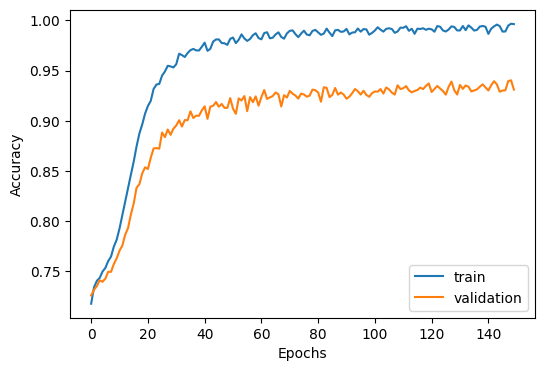

In [28]:
fig = plt.figure(figsize=(6,4))
plt.plot(train_acc_history, label='train')
plt.plot(val_acc_history, label='validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

Code used to sweep hyper parameters

In [4]:
class NeuralNetwork(nn.Module):
    def __init__(self, num_layers, num_nodes, activation):
        super().__init__()
        layers = []
        layers.append(nn.Linear(in_features=22, out_features=num_nodes))
        if activation == 'sigmoid':
            layers.append(nn.Sigmoid())
        elif activation == 'relu':
            layers.append(nn.ReLU())
        else:
            raise ValueError("Unsupported activation function")
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(in_features=num_nodes, out_features=num_nodes))
            if activation == 'sigmoid':
                layers.append(nn.Sigmoid())
            elif activation == 'relu':
                layers.append(nn.ReLU())
            else:
                raise ValueError("Unsupported activation function")
        layers.append(nn.Linear(in_features=num_nodes, out_features=4))
        self.linear_relu_stack = nn.Sequential(*layers)

    def forward(self, x):
        return self.linear_relu_stack(x)

def train_model(model, optimizer, criterion, train_loader, val_loader, epochs):
    train_acc_history = []
    val_acc_history = []
    for epoch in range(epochs):
        train_acc = 0.0
        for batch, (X, y) in enumerate(train_loader):
            optimizer.zero_grad()
            pred = model(X)
            loss = criterion(pred, y.long())
            loss.backward()
            optimizer.step()
            train_acc += (pred.argmax(dim=1) == y).type(torch.float).mean().item()
        train_acc /= len(train_loader)
        train_acc_history.append(train_acc)

        val_acc = 0.0
        with torch.no_grad():
            for batch, (X, y) in enumerate(val_loader):
                pred = model(X)
                val_acc += (pred.argmax(dim=1) == y).type(torch.float).mean().item()
            val_acc /= len(val_loader)
            val_acc_history.append(val_acc)

        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1} train accuracy: {train_acc:.4f}, validation accuracy: {val_acc:.4f}")
    return train_acc_history, val_acc_history

# Define hyperparameters
learning_rate = 0.001
epochs = 30

# Define different configurations of hyperparameters to sweep over
num_layers_list = [10]
num_nodes_list = [1000]
activation_functions = [ 'relu']

# Iterate over different hyperparameter configurations
for num_layers in num_layers_list:
    for num_nodes in num_nodes_list:
        for activation in activation_functions:
            torch.manual_seed(0);
            # Construct neural network
            print(f"Layers: {num_layers}, Nodes: {num_nodes}, Activation: {activation}")
            model = NeuralNetwork(num_layers, num_nodes, activation)
            optimizer = optim.Adam(model.parameters(), lr=learning_rate)
            criterion = nn.CrossEntropyLoss()

            # Train and evaluate the model
            train_model(model, optimizer, criterion, train_loader, val_loader, epochs)


Layers: 10, Nodes: 1000, Activation: relu
Epoch 5 train accuracy: 0.7395, validation accuracy: 0.7253


KeyboardInterrupt: 

In [5]:
train_acc_history = []
val_acc_history = []

for epoch in range(50):

    # Training loop
    train_acc = 0.0
    for batch, (X, y) in enumerate(train_loader):
        pred = NN(X) # predict logits
        loss = CrossEntropy(pred, y.type(torch.LongTensor)) # compute Cross Entropy loss
        loss.backward() # backward pass
        optimizer.step() # update step
        optimizer.zero_grad()
        train_acc += (pred.softmax(dim=1).argmax(dim=1) == y).type(torch.float).sum() / len(train_dataset)
    train_acc_history.append(train_acc)

    # Validation loop
    val_acc = 0.0
    with torch.no_grad():
        for batch, (X, y) in enumerate(val_loader):
            pred = NN(X)
            #loss = CrossEntropy(pred, y.type(torch.LongTensor))
            val_acc += (pred.softmax(dim=1).argmax(dim=1) == y).type(torch.float).sum() / len(val_dataset)
        val_acc_history.append(val_acc)

    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1} train accuracy:, {round(float(train_acc), 4)}, validation accuracy:, {round(float(val_acc), 4)}")

Epoch 5 train accuracy:, 0.7271, validation accuracy:, 0.7251
Epoch 10 train accuracy:, 0.7351, validation accuracy:, 0.7344
Epoch 15 train accuracy:, 0.7405, validation accuracy:, 0.7374
Epoch 20 train accuracy:, 0.7441, validation accuracy:, 0.7395
Epoch 25 train accuracy:, 0.7468, validation accuracy:, 0.7416
Epoch 30 train accuracy:, 0.7491, validation accuracy:, 0.7452
Epoch 35 train accuracy:, 0.7509, validation accuracy:, 0.7468
Epoch 40 train accuracy:, 0.7523, validation accuracy:, 0.747
Epoch 45 train accuracy:, 0.7531, validation accuracy:, 0.7485
Epoch 50 train accuracy:, 0.7538, validation accuracy:, 0.7487


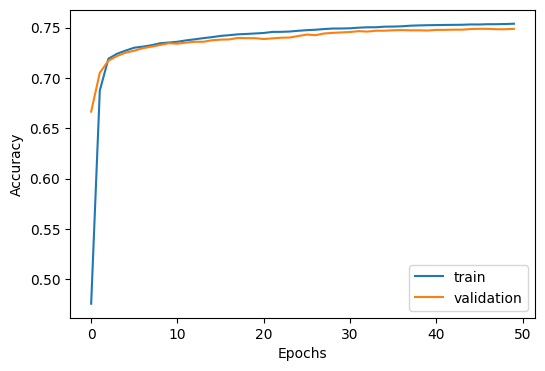

In [6]:
fig = plt.figure(figsize=(6,4))
plt.plot(train_acc_history, label='train')
plt.plot(val_acc_history, label='validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()